In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/debasisdotcom/name-entity-recognition-ner-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mostafa1221 
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/debasisdotcom/name-entity-recognition-ner-dataset


100%|██████████| 3.17M/3.17M [00:00<00:00, 750MB/s]

In [ ]:
# Install compatible versions of PyTorch and TorchText
!pip install torchtext==0.16.0  #torch==2.1.0

  Using cached torch-2.1.0-cp311-cp311-manylinux1_x86_64.whl.metadata (25 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.18.1-py3-none-manylinux1_x86_64.whl.m

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader ,Dataset

In [3]:
torch.__version__

'2.6.0+cu124'

In [4]:
df=pd.read_csv("/content/name-entity-recognition-ner-dataset/NER dataset.csv",encoding='unicode_escape')

In [5]:
df

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
...,...,...,...,...
1048570,NaN,they,PRP,O
1048571,NaN,responded,VBD,O
1048572,NaN,to,TO,O
1048573,NaN,the,DT,O


In [6]:
df["Tag"].value_counts()

,count
Tag,
O,887908
B-geo,37644
B-tim,20333
B-org,20143
I-per,17251
B-per,16990
I-org,16784
B-gpe,15870
I-geo,7414


In [7]:
def prepared_tag(t):
    if t in ["B-art","B-eve","I-art","I-eve","B-nat","I-gpe","I-nat"]:
        return "O"
    else:
        return t

In [8]:
df["Tag"]=df["Tag"].apply(prepared_tag)

In [9]:
df["Tag"].value_counts()

,count
Tag,
O,889618
B-geo,37644
B-tim,20333
B-org,20143
I-per,17251
B-per,16990
I-org,16784
B-gpe,15870
I-geo,7414


In [10]:
for i in df["Tag"].unique():
    print(i)

O
B-geo
B-gpe
B-per
I-geo
B-org
I-org
B-tim
I-per
I-tim


In [11]:
lapels ={l:i for i,l in enumerate(df["Tag"].unique())}
lapels

{'O': 0,
 'B-geo': 1,
 'B-gpe': 2,
 'B-per': 3,
 'I-geo': 4,
 'B-org': 5,
 'I-org': 6,
 'B-tim': 7,
 'I-per': 8,
 'I-tim': 9}

In [12]:
def xx(w):
    for l,i in lapels.items():
        if l==w:
            return i
            break
df["enc_lapels"] =df["Tag"].apply(xx)
df[10:20]

,Sentence #,Word,POS,Tag,enc_lapels
10,NaN,war,NN,O,0
11,NaN,in,IN,O,0
12,NaN,Iraq,NNP,B-geo,1
13,NaN,and,CC,O,0
14,NaN,demand,VB,O,0
15,NaN,the,DT,O,0
16,NaN,withdrawal,NN,O,0
17,NaN,of,IN,O,0
18,NaN,British,JJ,B-gpe,2
19,NaN,troops,NNS,O,0


In [13]:
df=df.ffill()
df

,Sentence #,Word,POS,Tag,enc_lapels
0,Sentence: 1,Thousands,NNS,O,0
1,Sentence: 1,of,IN,O,0
2,Sentence: 1,demonstrators,NNS,O,0
3,Sentence: 1,have,VBP,O,0
4,Sentence: 1,marched,VBN,O,0
...,...,...,...,...,...
1048570,Sentence: 47959,they,PRP,O,0
1048571,Sentence: 47959,responded,VBD,O,0
1048572,Sentence: 47959,to,TO,O,0
1048573,Sentence: 47959,the,DT,O,0


In [14]:
df["Sentence #"].nunique()

47959

In [15]:
def SentenceBuilder(x):
    iterator = zip(x["Word"].values.tolist(),
                   x["enc_lapels"].values.tolist())
    return [(word, tag) for word, tag in iterator]

In [16]:
sentences = df.groupby("Sentence #").apply(SentenceBuilder, include_groups=False).tolist()

print(sentences[0])

[('Thousands', 0), ('of', 0), ('demonstrators', 0), ('have', 0), ('marched', 0), ('through', 0), ('London', 1), ('to', 0), ('protest', 0), ('the', 0), ('war', 0), ('in', 0), ('Iraq', 1), ('and', 0), ('demand', 0), ('the', 0), ('withdrawal', 0), ('of', 0), ('British', 2), ('troops', 0), ('from', 0), ('that', 0), ('country', 0), ('.', 0)]


In [17]:

all_s=[]
all_l=[]
for ss in sentences:
    s=[]
    t=[]
    for w,l in ss :
        t.append(l)
        s.append(w)
    all_s.append(s)
    all_l.append(t)

print(all_s[0],all_l[0])

['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.'] [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0]


In [18]:
print(len(all_s),len(all_l))

47959 47959


In [ ]:
from torchtext.vocab import build_vocab_from_iterator

In [ ]:
special_tokens=["<PAD>","<UNK>"]

In [ ]:
our_vocab=build_vocab_from_iterator(all_s,specials=special_tokens,max_tokens=4000)

In [ ]:
len(our_vocab)

4000

In [ ]:
our_vocab.set_default_index(our_vocab[special_tokens[1]])

In [ ]:
our_vocab[special_tokens[1]]

1

In [ ]:
idss=our_vocab.lookup_indices(all_s[44])
print(idss)

[10, 86, 20, 3506, 12, 8, 2352, 7, 153, 348, 4, 176, 1, 1, 20, 7, 1, 6, 8, 3993, 75, 4, 90, 36, 20, 580, 1038, 7, 8, 1, 1, 24, 2, 1327, 3]


In [ ]:
tt=our_vocab.lookup_tokens(idss)
print(tt)

['The', 'group', 'was', 'waiting', 'for', 'a', 'flight', 'to', 'South', 'Africa', ',', 'where', '<UNK>', '<UNK>', 'was', 'to', '<UNK>', 'in', 'a', 'concert', 'Thursday', ',', 'when', 'it', 'was', 'denied', 'access', 'to', 'a', '<UNK>', '<UNK>', 'at', 'the', 'airport', '.']


In [19]:
def pad_seq(s,m,p_t):
  if len(s)>=m:
    return s[:m]
  else:
    return s + [p_t] * (m-len(s))

def pad_t(m,t):
    if m >=len(t):
        return t + [-100] * (m-len(t))
    else:
        return t[:m]



In [ ]:
print(pad_seq([3,4,5],10,0))
print(pad_t(10,[0,1,2]))

[3, 4, 5, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 2, -100, -100, -100, -100, -100, -100, -100]


In [20]:
df_d=pd.DataFrame({"tokens_s":all_s,"labels_enc":all_l})
df_d

,tokens_s,labels_enc
0,"[Thousands, of, demonstrators, have, marched, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ..."
1,"[Iranian, officials, say, they, expect, to, ge...","[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[Helicopter, gunships, Saturday, pounded, mili...","[0, 0, 7, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 5, ..."
3,"[They, left, after, a, tense, hour-long, stand...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,"[U.N., relief, coordinator, Jan, Egeland, said...","[1, 0, 0, 3, 8, 0, 7, 0, 1, 0, 2, 0, 2, 0, 0, ..."
...,...,...
47954,"[Opposition, leader, Mir, Hossein, Mousavi, ha...","[0, 0, 0, 3, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
47955,"[On, Thursday, ,, Iranian, state, media, publi...","[0, 7, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 0, ..."
47956,"[Following, Iran, 's, disputed, June, 12, elec...","[0, 1, 0, 0, 7, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
47957,"[Since, then, ,, authorities, have, held, publ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [21]:
len(df_d["labels_enc"][1]) , len(df_d["tokens_s"][1])

(25, 25)

<Axes: >

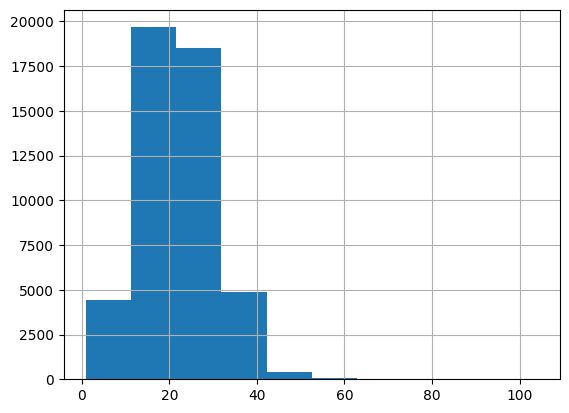

In [22]:
df_d["tokens_s"].map(len).hist()

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
x_train,x_test,y_train,y_test=train_test_split(np.array(df_d["tokens_s"]),np.array(df_d["labels_enc"]),test_size=0.2,shuffle=True,random_state=42)

In [ ]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((38367,), (9592,), (38367,), (9592,))

In [ ]:
class OurData(Dataset):

    def __init__(self,s,l,vocab):
        self.s =s
        self.l=l
        self.vocab=vocab

    def __len__(self):
        return len(s)

    def __getitem__(self,i):

        x=pad_seq(self.s.values[i],60,"<PAD>")
        y=pad_t(60,self.l.values[i])
        input=torch.tensor(self.vocab.lookup_indices(x), dtype=torch.long)
        target=torch.tensor(y, dtype=torch.float)

        return input,target



In [ ]:
x_train.values[0]

['South',
 'Korea',
 "'s",
 'government',
 'Tuesday',
 'also',
 'unveiled',
 'a',
 'so-called',
 'Green',
 'New',
 'Job',
 'Creation',
 'Plan',
 ',',
 'expected',
 'to',
 'create',
 '9,60,000',
 'new',
 'jobs',
 '.']

In [ ]:
our_train_data_set=OurData(x_train,y_train,our_vocab)
our_test_data_set=OurData(x_test,y_test,our_vocab)

NameError: name 'our_vocab' is not defined

In [ ]:
our_train_data_set[0]

(tensor([ 153,  232,   11,   35,   73,   49, 3503,    8, 1778, 3964,  170,    1,
            1,    1,    4,  194,    7, 1273,    1,   69, 1141,    3,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]),
 tensor([   1.,    4.,    0.,    0.,    7.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0., -100., -100., -100., -100., -100., -100., -100., -100.,
         -100., -100., -100., -100., -100., -100., -100., -100., -100., -100.,
         -100., -100., -100., -100., -100., -100., -100., -100., -100., -100.,
         -100., -100., -100., -100., -100., -100., -100., -100., -100., -100.]))

In [ ]:
our_train_data_loader=DataLoader(our_train_data_set,batch_size=32,shuffle=True)
our_test_data_loader=DataLoader(our_test_data_set,batch_size=32,shuffle=False)

In [ ]:
for i,t in our_train_data_loader :
  print(i.shape)
  print(t.shape)
  break

RuntimeError: Numpy is not available

In [ ]:
!pip install numpy --upgrade

In [ ]:
!pip install torch --upgrade

  Using cached torch-2.7.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (29 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.6.77-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.6.77-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.6.80-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.5.1.17-py3-none-manylinux_2_28_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.6.4.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.3.0.4-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.7.77-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.7.1.2-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.6 kB)
  Using cache

In [ ]:
len(lapels),len(our_vocab)

(10, 4000)

In [ ]:
class OurLSTM(nn.Module):
  def __init__(self):

    super(OurLSTM,self).__init__()


    self.embed=nn.Embedding(len(our_vocab),100,0)
    self.lstm=nn.LSTM(100,64,num_layers=2,batch_first=True,bidirectional=True)
    self.liner1=nn.Linear(64*2,32)
    self.output=nn.Linear(32,10+1)
    self.drop_out=nn.Dropout(.25)
    self.relu=nn.ReLU()

  def forward (self,x):
    x=self.embed(x)
    out,_=self.lstm(x)
    x=self.liner1(out)
    x=self.relu(x)
    x=self.drop_out(x)
    x=self.output(x)

    return x.shape

In [ ]:
our_lstm_model=OurLSTM()
our_lstm_model(torch.randint(0,100,(32,60)))

torch.Size([32, 60, 11])

In [ ]:
our_loss=nn.CrossEntropyLoss(ignore_index=-100)
our_optimizer =torch.optim.AdamW(our_lstm_model.parameters(),lr=.0001)

In [ ]:
def our_accuracy(t,y):
  t=t  #32*60
  y=torch.argmax(torch.softmax(y,dim=-1),dim=-1).squeeze() #32*60*11 >> 32*60*1 >> 32*60
  mask = (t != -100)
  correct = (t==y)*mask
  correct_count = correct.sum().item()
  total_count = mask.sum().item()
  return correct_count / total_count if total_count > 0 else 0


In [ ]:
print(our_accuracy(torch.ones((32,60)),torch.rand((32,60,11))))

0.0859375


In [25]:
!pip install transformers --quiet

In [26]:
from transformers import AutoTokenizer, AutoModel

In [27]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
our_bert_model = AutoModel.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [28]:
device="cuda" if torch.cuda.is_available() else "cpu"

In [29]:
class OurDataBert(Dataset):

    def __init__(self,s,l,lapels):
        self.s = s
        self.l=l
        self.lapels=lapels


    def __len__(self):
        return len(self.s)

    def __getitem__(self,i):

        text=self.s[i]
        tokenized_input = tokenizer(text, is_split_into_words=True, truncation=True, padding='max_length', max_length=100, return_tensors="pt")
        input=tokenized_input

        y=self.align_labels_with_tokens(self.l[i],input)

        target=torch.tensor(y, dtype=torch.long)

        return input,target



    def align_labels_with_tokens(self, labels, tokenized_input):
      aligned_labels = []
      word_ids = tokenized_input.word_ids()

      previous_word_id = None
      for word_id in word_ids:
          if word_id is None:
              aligned_labels.append(-100)
          elif word_id != previous_word_id:
              aligned_labels.append(labels[word_id])
          else:
              aligned_labels.append(labels[word_id])
          previous_word_id = word_id

      #aligned_labels=pad_t(100,aligned_labels)

      return aligned_labels

In [30]:
lapels

{'O': 0,
 'B-geo': 1,
 'B-gpe': 2,
 'B-per': 3,
 'I-geo': 4,
 'B-org': 5,
 'I-org': 6,
 'B-tim': 7,
 'I-per': 8,
 'I-tim': 9}

In [ ]:
tokenizer

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [ ]:
 tokenized_input = tokenizer(x_train[0], is_split_into_words=True, truncation=True, padding='max_length', max_length=100, return_tensors="pt")
 tokenized_input.word_ids()

[None,
 0,
 1,
 2,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 8,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 18,
 18,
 18,
 18,
 19,
 20,
 21,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [31]:
our_train_data_set_bert=OurDataBert(x_train,y_train,lapels)
our_test_data_set_bert=OurDataBert(x_test,y_test,lapels)

In [ ]:
our_train_data_set_bert[5]

({'input_ids': tensor([[  101,  9302,  2343, 27278, 17532,  2003,  2988,  2000,  2031,  2409,
           2010,  3036,  2749,  2000,  2224,  1000,  2019,  3707,  7345,  1000,
           2000,  5441,  1996,  2783, 13236,  1011,  2543,  2007,  3956,  1012,
            102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  

In [32]:
our_train_data_loader_bert=DataLoader(our_train_data_set_bert,batch_size=32,shuffle=True)
our_test_data_loader_bert=DataLoader(our_test_data_set_bert,batch_size=32,shuffle=False)

In [33]:
for i , j in our_train_data_loader_bert :
  print(i["input_ids"].shape)
  print(i["attention_mask"].shape)
  print(j.shape)
  break

torch.Size([32, 1, 100])
torch.Size([32, 1, 100])
torch.Size([32, 100])


In [34]:
class BertModel_1(nn.Module):
  def __init__(self,bert):

    super (BertModel_1,self).__init__()
    self.bert=bert
    self.l1=nn.Linear(768,256)
    self.l2=nn.Linear(256,64)
    self.output=nn.Linear(64,11)
    self.rlu=nn.ReLU()
    self.drop_o=nn.Dropout(.25)

  def forward(self,input_ids,attention_mask):
    x=self.bert(input_ids, attention_mask).last_hidden_state
    x=self.l1(x)
    x=self.rlu(x)
    x=self.drop_o(x)
    x=self.l2(x)
    x=self.rlu(x)
    x=self.drop_o(x)
    x=self.output(x)

    return x



In [35]:
class BertModel_1(nn.Module):
    def __init__(self, bert):

        super(BertModel_1, self).__init__()

        self.bert = bert
        self.dropout = nn.Dropout(0.25)
        self.linear1 = nn.Linear(768, 384)
        self.linear2 = nn.Linear(384, 64)
        self.linear3 = nn.Linear(64, 11)
        self.relu = nn.ReLU()


    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(input_ids, attention_mask).last_hidden_state
        output = self.linear1(pooled_output)
        output = self.relu(output)
        output = self.dropout(output)

        output = self.linear2(output)
        output = self.relu(output)
        output = self.dropout(output)

        output = self.linear3(output)
        #output = self.sigmoid(output)
        return output

In [36]:
for p in our_bert_model.parameters():
    p.requires_grad = False

our_bert_model_1=BertModel_1(our_bert_model).to(device)
our_bert_model_1(torch.randint(low=0,high=1000,size=(32,100)).to(device),torch.randint(low=0,high=1000,size=(32,100)).to(device)).shape

torch.Size([32, 100, 11])

In [37]:
def our_accuracy(t,y):
  t=t.flatten()  #32*60  >>1920
  y=torch.argmax(torch.softmax(y,dim=-1),dim=-1).squeeze().flatten() #32*60*10 >> 32*60*1 >> 32*60 >>1920
  mask = (t != -100)
  correct = (t==y)*mask
  correct_count = correct.sum().item()
  total_count = mask.sum().item()
  return correct_count , total_count

# [1,1,1,1,0,0,0,-100,-100]  [1,1,1,1,1,1,1,0,0]  [1,0,1,1,1,0,1,-100,-100]


In [38]:
our_loss=nn.CrossEntropyLoss(ignore_index=-100)
our_optimizer =torch.optim.AdamW(our_bert_model_1.parameters(),lr=.0001)

In [39]:
!pip install tensorboard

In [40]:
from torch.utils.tensorboard import SummaryWriter

In [41]:
writer = SummaryWriter('runss')

In [ ]:
def our_train(epochs=10,our_model=our_bert_model_1):

    train_loss_l=[]
    test_loss_l=[]
    train_accuracy_l =[]
    test_accuracy_l =[]

    for epoch in range(epochs):


      train_loss_v=0.0

      test_loss_v=0.0


      train_correct = 0.0
      train_total = 0.0

      test_correct = 0.0
      test_total = 0.0


      for x_train_batch , y_train_batch in our_train_data_loader_bert :

        x_train_batch=x_train_batch.to(device)
        y_train_batch=y_train_batch.to(device)

        our_model.train()

        y_train_pred=our_model(x_train_batch["input_ids"].squeeze(1) ,x_train_batch["attention_mask"].squeeze(1) ).squeeze(1)

        train_loss=our_loss(y_train_pred.view(-1,10),y_train_batch.view(-1))

        our_optimizer.zero_grad()
        train_loss.backward()
        our_optimizer.step()

        train_loss_v +=train_loss.item()

        correct_train, total_train = our_accuracy(y_train_batch, y_train_pred)
        train_correct += correct_train
        train_total += total_train

      with torch.inference_mode():

        our_model.eval()

        for x_test_batch , y_test_batch in our_test_data_loader_bert :
            x_test_batch=x_test_batch.to(device)
            y_test_batch=y_test_batch.to(device)

            y_test_pred=our_model(x_test_batch["input_ids"].squeeze(1) ,x_test_batch["attention_mask"].squeeze(1) ).squeeze(1)

            test_loss=our_loss(y_test_pred.view(-1,10),y_test_batch.view(-1))

            test_loss_v +=test_loss.item()

            correct_test, total_test = our_accuracy(y_test_batch, y_test_pred)
            test_correct += correct_test
            test_total += total_test


      train_acc = train_correct / train_total if train_total > 0 else 0
      test_acc = test_correct / test_total if test_total > 0 else 0

      train_loss_l.append(train_loss_v/our_train_data_set_bert.__len__())
      test_loss_l.append(test_loss_v/our_test_data_set_bert.__len__())

      train_accuracy_l.append(train_acc)
      test_accuracy_l.append(test_acc)



      writer.add_scalar("Loss/Train", train_loss_l[-1], epoch)
      writer.add_scalar("Loss/Test", test_loss_l[-1], epoch)
      writer.add_scalar("Accuracy/Train", train_accuracy_l[-1], epoch)
      writer.add_scalar("Accuracy/Test", test_accuracy_l[-1], epoch)

      print(f"at epoch = {epoch+1} || train loss = {train_loss_l[-1]:.3f} and test loss = {test_loss_l[-1]:.3f} || train accuracy = {train_accuracy_l[-1]:.3f} and test accuracy = {test_accuracy_l[-1]:.3f}")

    writer.close()
    return train_loss_l,test_loss_l,train_accuracy_l,test_accuracy_l


In [ ]:
train_loss_l,test_loss_l,train_accuracy_l,test_accuracy_l=our_train(epochs=10,our_model=our_bert_model_1)

at epoch = 1 || train loss = 0.015 and test loss = 0.008 || train accuracy = 0.876 and test accuracy = 0.918
at epoch = 2 || train loss = 0.009 and test loss = 0.007 || train accuracy = 0.918 and test accuracy = 0.929
at epoch = 3 || train loss = 0.008 and test loss = 0.007 || train accuracy = 0.925 and test accuracy = 0.933
at epoch = 4 || train loss = 0.007 and test loss = 0.006 || train accuracy = 0.929 and test accuracy = 0.937
at epoch = 5 || train loss = 0.007 and test loss = 0.006 || train accuracy = 0.932 and test accuracy = 0.939
at epoch = 6 || train loss = 0.007 and test loss = 0.006 || train accuracy = 0.934 and test accuracy = 0.939
at epoch = 7 || train loss = 0.007 and test loss = 0.006 || train accuracy = 0.935 and test accuracy = 0.941
at epoch = 8 || train loss = 0.007 and test loss = 0.006 || train accuracy = 0.936 and test accuracy = 0.942
at epoch = 9 || train loss = 0.006 and test loss = 0.006 || train accuracy = 0.937 and test accuracy = 0.943
at epoch = 10 || tr

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runss

In [53]:
import copy
import matplotlib.pyplot as plt
import torch


def prepared_tag(t):
    if t in ["B-art","B-eve","I-art","I-eve","B-nat","I-gpe","I-nat"]:
        return "O"
    else:
        return t

def sentence_builder(x):
    iterator = zip(x["Word"].values.tolist(),
                   x["enc_labels"].values.tolist())
    return [(word, tag) for word, tag in iterator]



def prepare_data (sentence):
  tokens=tokenizer(sentence)
  tokens_l=[]
  for token in tokens :
    if token.isalnum()== False :
      continue
    tokens_l.append(token.lower())

  return tokens_l


def pad_sentence (sentence_l,max_len,pad_token):
  if len(sentence_l)>=max_len:
    return sentence_l[:max_len]
  else:
    return sentence_l + [pad_token] * (max_len-len(sentence_l))

def pad_labels(max_len,l_labels):
    if max_len >=len(l_labels):
        return l_labels + [-100] * (max_len-len(l_labels))
    else:
        return l_labels[:max_len]


def our_accuracy(t,y):
  t=t.flatten()  #32*60  >>1920
  y=torch.argmax(torch.softmax(y,dim=-1),dim=-1).squeeze().flatten() #32*60*10 >> 32*60*1 >> 32*60 >>1920
  mask = (t != -100)
  correct = (t==y)*mask
  correct_count = correct.sum().item()
  total_count = mask.sum().item()
  return correct_count , total_count

# [1,1,1,1,0,0,0,-100,-100]  [1,1,1,1,1,1,1,0,0]  [1,0,1,1,1,0,1,-100,-100]



class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.best_accuracy = None  # New attribute to track best accuracy
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss, val_accuracy):
        if self.best_loss is None or val_loss < self.best_loss:  # Update if val_loss is better
            self.best_loss = val_loss
            self.best_accuracy = val_accuracy  # Update best accuracy along with best loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}. " \
                          # f"Best Loss: {self.best_loss:.4f}, Best Accuracy: {self.best_accuracy:.2f}%"

        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}. " \
                          # f"Best Loss: {self.best_loss:.4f}, Best Accuracy: {self.best_accuracy:.2f}%"

        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs. " \
                          # f"Best Loss: {self.best_loss:.4f}, Best Accuracy: {self.best_accuracy:.2f}%"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs. " \
                              f"Best Loss: {self.best_loss:.4f}, Best Accuracy: {self.best_accuracy:.2f}%"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False


def save_checkpoint(model, optimizer, epoch, loss, filename="model_checkpoint.pth"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filename)


def plot_l_a(train_loss,test_loss,train_accuracy,test_accuracy,name):

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    axs[0].plot(train_loss, label='Training Loss')
    axs[0].plot(test_loss, label='Test Loss')
    axs[0].set_title('Training and Test Loss over Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    #axs[0].set_ylim([0, 1])
    axs[0].legend()

    axs[1].plot(train_accuracy, label='Training Accuracy')
    axs[1].plot(test_accuracy, label='Test Accuracy')
    axs[1].set_title('Training and Test Accuracy over Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    #axs[1].set_ylim([0, 100])
    axs[1].legend()

    plt.tight_layout()
    plt.savefig (r'D:\Named_Entity_Recognition_(NER)\images' + f"\{name}")
    plt.show()




def our_predict_bert(s,our_model, labels, device):

    len_s=len(s.split())

    tokenized_input = tokenizer(s, is_split_into_words=True, truncation=True, padding='max_length', max_length=100, return_tensors="pt").unsqueeze(0).to(device)

    out=our_model(tokenized_input["input_ids"].squeeze(1) ,tokenized_input["attention_mask"].squeeze(1) ).squeeze(1)
    out=torch.argmax(torch.softmax(out,dim=-1),dim=-1).squeeze()
    out=out.cpu().detach().numpy()
    f_out=[]
    for i in out:
        for k,v in labels.items():
            if i==v :
                f_out.append(k)
                break

    return f_out[:len_s]

In [43]:
config_hp={"MAX_LEN":100,
"SPECIAL_TOKENS":["<PAD>","<UNK>"],
"MAX_VOCAB":4000,
"BATCH_SIZE":32,
"N_CLASSES":10,
"EMBEDDING_SIZE":100,
"LSTM_HIDDEN_SIZE":64,
"LSTM_N_LAYERS":2,
"LEARNING_RATE":0.0001,
"EPOCHS":20,
}


In [45]:
from tqdm import tqdm
early_stopping = EarlyStopping(patience=5, min_delta=0)


In [46]:

class BertModel(nn.Module):
    def __init__(self, bert):

        super(BertModel, self).__init__()

        self.bert = bert
        self.dropout = nn.Dropout(0.25)
        self.linear1 = nn.Linear(768, 384)
        self.linear2 = nn.Linear(384, 64)
        self.linear3 = nn.Linear(64, 11)
        self.relu = nn.ReLU()


    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(input_ids, attention_mask).last_hidden_state
        output = self.linear1(pooled_output)
        output = self.relu(output)
        output = self.dropout(output)

        output = self.linear2(output)
        output = self.relu(output)
        output = self.dropout(output)

        output = self.linear3(output)

        return output

bert_model = AutoModel.from_pretrained("google-bert/bert-base-uncased")
for p in bert_model.parameters():
    p.requires_grad = False

our_bert_model=BertModel(bert_model).to(device)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch = 0: 100%|██████████| 1199/1199 [03:23<00:00,  5.90it/s]


at epoch = 1 || train loss = 0.010 and test loss = 0.008 || train accuracy = 0.904 and test accuracy = 0.924


Epoch = 1: 100%|██████████| 1199/1199 [03:23<00:00,  5.90it/s]


at epoch = 2 || train loss = 0.008 and test loss = 0.007 || train accuracy = 0.923 and test accuracy = 0.933
Checkpoint saved at epoch 2.


Epoch = 2: 100%|██████████| 1199/1199 [03:23<00:00,  5.90it/s]


at epoch = 3 || train loss = 0.008 and test loss = 0.006 || train accuracy = 0.928 and test accuracy = 0.936


Epoch = 3: 100%|██████████| 1199/1199 [03:22<00:00,  5.91it/s]


at epoch = 4 || train loss = 0.007 and test loss = 0.006 || train accuracy = 0.932 and test accuracy = 0.938
Checkpoint saved at epoch 4.


Epoch = 4: 100%|██████████| 1199/1199 [03:23<00:00,  5.90it/s]


at epoch = 5 || train loss = 0.007 and test loss = 0.006 || train accuracy = 0.934 and test accuracy = 0.940


Epoch = 5: 100%|██████████| 1199/1199 [03:30<00:00,  5.70it/s]


at epoch = 6 || train loss = 0.007 and test loss = 0.006 || train accuracy = 0.936 and test accuracy = 0.942
Checkpoint saved at epoch 6.


Epoch = 6: 100%|██████████| 1199/1199 [03:26<00:00,  5.81it/s]


at epoch = 7 || train loss = 0.007 and test loss = 0.006 || train accuracy = 0.937 and test accuracy = 0.942


Epoch = 7: 100%|██████████| 1199/1199 [03:31<00:00,  5.66it/s]


at epoch = 8 || train loss = 0.006 and test loss = 0.006 || train accuracy = 0.938 and test accuracy = 0.943
Checkpoint saved at epoch 8.


Epoch = 8: 100%|██████████| 1199/1199 [03:26<00:00,  5.82it/s]


at epoch = 9 || train loss = 0.006 and test loss = 0.006 || train accuracy = 0.939 and test accuracy = 0.944


Epoch = 9: 100%|██████████| 1199/1199 [03:23<00:00,  5.90it/s]


at epoch = 10 || train loss = 0.006 and test loss = 0.005 || train accuracy = 0.940 and test accuracy = 0.945
Checkpoint saved at epoch 10.


Epoch = 10: 100%|██████████| 1199/1199 [03:24<00:00,  5.86it/s]


at epoch = 11 || train loss = 0.006 and test loss = 0.005 || train accuracy = 0.941 and test accuracy = 0.945


Epoch = 11: 100%|██████████| 1199/1199 [03:26<00:00,  5.80it/s]


at epoch = 12 || train loss = 0.006 and test loss = 0.005 || train accuracy = 0.941 and test accuracy = 0.946
Checkpoint saved at epoch 12.


Epoch = 12: 100%|██████████| 1199/1199 [03:23<00:00,  5.91it/s]


at epoch = 13 || train loss = 0.006 and test loss = 0.005 || train accuracy = 0.942 and test accuracy = 0.946


Epoch = 13: 100%|██████████| 1199/1199 [03:22<00:00,  5.91it/s]


at epoch = 14 || train loss = 0.006 and test loss = 0.005 || train accuracy = 0.943 and test accuracy = 0.946
Checkpoint saved at epoch 14.


Epoch = 14: 100%|██████████| 1199/1199 [03:22<00:00,  5.91it/s]


at epoch = 15 || train loss = 0.006 and test loss = 0.005 || train accuracy = 0.943 and test accuracy = 0.947


Epoch = 15: 100%|██████████| 1199/1199 [03:23<00:00,  5.91it/s]


at epoch = 16 || train loss = 0.006 and test loss = 0.005 || train accuracy = 0.943 and test accuracy = 0.947
Checkpoint saved at epoch 16.


Epoch = 16: 100%|██████████| 1199/1199 [03:22<00:00,  5.91it/s]


at epoch = 17 || train loss = 0.006 and test loss = 0.005 || train accuracy = 0.944 and test accuracy = 0.948


Epoch = 17: 100%|██████████| 1199/1199 [03:22<00:00,  5.91it/s]


at epoch = 18 || train loss = 0.006 and test loss = 0.005 || train accuracy = 0.944 and test accuracy = 0.948
Checkpoint saved at epoch 18.


Epoch = 18: 100%|██████████| 1199/1199 [03:23<00:00,  5.90it/s]


at epoch = 19 || train loss = 0.005 and test loss = 0.005 || train accuracy = 0.945 and test accuracy = 0.948


Epoch = 19: 100%|██████████| 1199/1199 [03:22<00:00,  5.91it/s]


at epoch = 20 || train loss = 0.005 and test loss = 0.005 || train accuracy = 0.945 and test accuracy = 0.948
Checkpoint saved at epoch 20.
Training completed without early stopping. Final model saved.


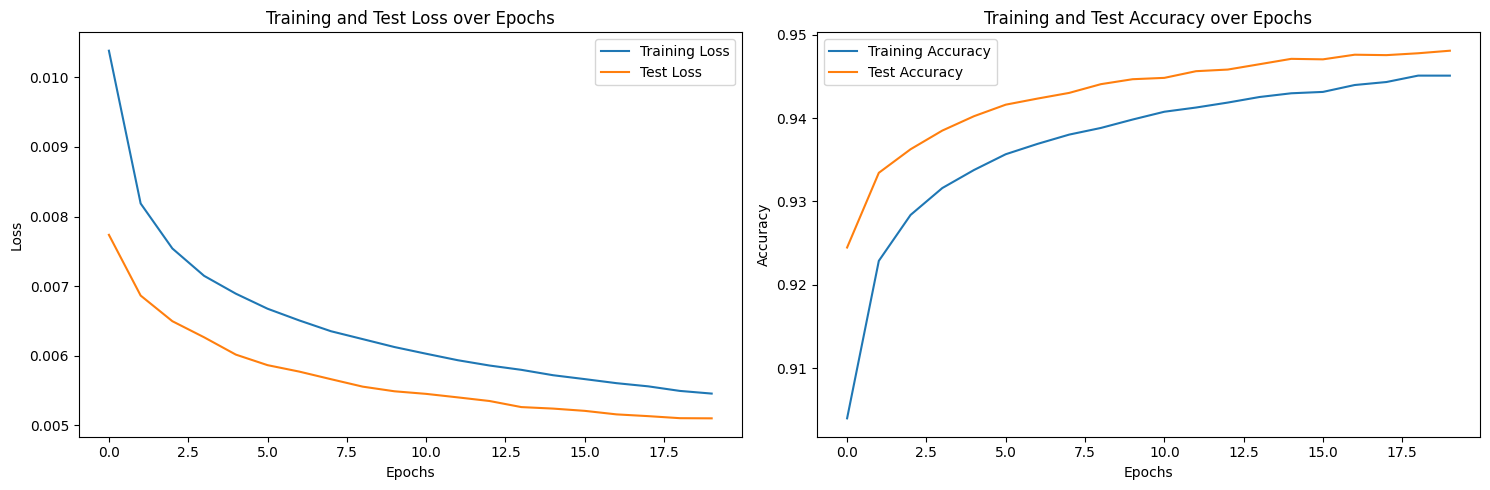

In [49]:

def our_train_bert(epochs,our_model,our_accuracy):

    our_loss=nn.CrossEntropyLoss(ignore_index=-100)
    our_optimizer =torch.optim.AdamW(our_model.parameters(),lr=config_hp["LEARNING_RATE"])

    writer = SummaryWriter('runs\bert')

    train_loss_l=[]
    test_loss_l=[]
    train_accuracy_l =[]
    test_accuracy_l =[]

    for epoch in range(epochs):


      train_loss_v=0.0

      test_loss_v=0.0


      train_correct = 0.0
      train_total = 0.0

      test_correct = 0.0
      test_total = 0.0

      our_model.train()
      for x_train_batch , y_train_batch in tqdm (our_train_data_loader_bert,f"Epoch = {epoch}") :

        x_train_batch=x_train_batch.to(device)
        y_train_batch=y_train_batch.to(device)



        y_train_pred=our_model(x_train_batch["input_ids"].squeeze(1) ,x_train_batch["attention_mask"].squeeze(1) ).squeeze(1)

        train_loss=our_loss(y_train_pred.view(-1,11),y_train_batch.view(-1))

        our_optimizer.zero_grad()
        train_loss.backward()
        our_optimizer.step()

        train_loss_v +=train_loss.item()

        correct_train, total_train = our_accuracy(y_train_batch, y_train_pred)
        train_correct += correct_train
        train_total += total_train

      our_model.eval()
      with torch.inference_mode():

        for x_test_batch , y_test_batch in our_test_data_loader_bert :

            x_test_batch=x_test_batch.to(device)
            y_test_batch=y_test_batch.to(device)

            y_test_pred=our_model(x_test_batch["input_ids"].squeeze(1) ,x_test_batch["attention_mask"].squeeze(1) ).squeeze(1)

            test_loss=our_loss(y_test_pred.view(-1,11),y_test_batch.view(-1))

            test_loss_v +=test_loss.item()

            correct_test, total_test = our_accuracy(y_test_batch, y_test_pred)
            test_correct += correct_test
            test_total += total_test


      train_acc = train_correct / train_total if train_total > 0 else 0
      test_acc = test_correct / test_total if test_total > 0 else 0

      train_loss_l.append(train_loss_v/our_train_data_set_bert.__len__())
      test_loss_l.append(test_loss_v/our_test_data_set_bert.__len__())

      train_accuracy_l.append(train_acc)
      test_accuracy_l.append(test_acc)


      writer.add_scalar("Loss/Train", train_loss_l[-1], epoch)
      writer.add_scalar("Loss/Test", test_loss_l[-1], epoch)
      writer.add_scalar("Accuracy/Train", train_accuracy_l[-1], epoch)
      writer.add_scalar("Accuracy/Test", test_accuracy_l[-1], epoch)


      print(f"at epoch = {epoch+1} || train loss = {train_loss_l[-1]:.3f} and test loss = {test_loss_l[-1]:.3f} || train accuracy = {train_accuracy_l[-1]:.3f} and test accuracy = {test_accuracy_l[-1]:.3f}")

      if (epoch + 1) % 2 == 0:
            save_checkpoint(our_model,our_optimizer,epoch + 1, test_loss_l[-1],r'/content/best_model_bert\model_checkpoint.pth')
            print(f"Checkpoint saved at epoch {epoch + 1}.")

      if early_stopping(our_model, test_loss_l[-1],test_accuracy_l[-1]):
            print(early_stopping.status)
            save_checkpoint(our_model,our_optimizer,epoch + 1, test_loss_l[-1], r'/content/best_model_bert\best_model.pth')
            print("Early stopping triggered!")
            writer.close()
            break

    if early_stopping.counter < early_stopping.patience:
        save_checkpoint(our_model, our_optimizer, epoch+1, test_loss_l[-1], r'/content/best_model_bert\final_model.pth')
        print("Training completed without early stopping. Final model saved.")

    return train_loss_l,test_loss_l,train_accuracy_l,test_accuracy_l



if __name__ == "__main__":
    train_loss_l,test_loss_l,train_accuracy_l,test_accuracy_l=our_train_bert(epochs=config_hp["EPOCHS"],our_model=our_bert_model,our_accuracy=our_accuracy)

    plot_l_a(train_loss_l,test_loss_l,train_accuracy_l,test_accuracy_l,"bert_plot_training_results.png")



In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

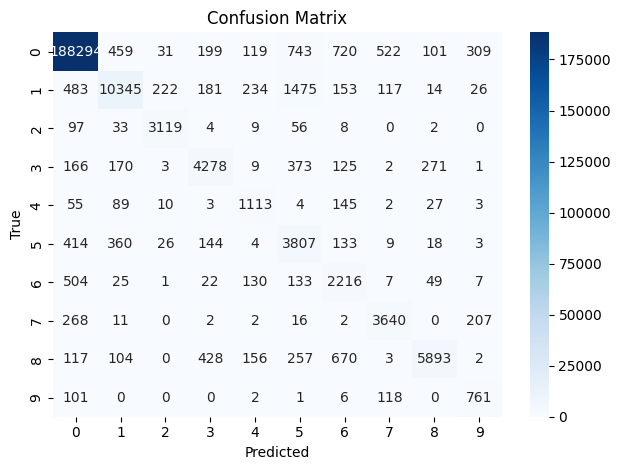

In [51]:
bert_model = AutoModel.from_pretrained("google-bert/bert-base-uncased")
for p in bert_model.parameters():
    p.requires_grad = False

our_bert_model=BertModel(bert_model).to(device)
checkpoint_bert = torch.load(r"/content/best_model_bert\final_model.pth")
our_bert_model.load_state_dict(checkpoint_bert['model_state_dict'])


def evaluation_test_bert():

    our_bert_model.eval()
    with torch.inference_mode():

        pred_l=[]
        true_l=[]
        for x_test_batch , y_test_batch in our_test_data_loader_bert :
            x_test_batch=x_test_batch.to(device)
            y_test_batch=y_test_batch.to(device)

            y_test_pred=our_bert_model(x_test_batch['input_ids'].squeeze(1),x_test_batch['attention_mask'].squeeze(1)).squeeze(1)


            y_test_pred=torch.argmax(torch.softmax(y_test_pred,dim=-1),dim=-1).squeeze().flatten().cpu().detach().numpy()


            y_test_batch=y_test_batch.flatten().cpu().detach().numpy()

            pred_l.extend(y_test_pred)
            true_l.extend(y_test_batch)

    pred_f=[]
    true_f=[]
    for true_label, pred_label in zip(true_l, pred_l):
        if true_label != -100:
            true_f.append(true_label)
            pred_f.append(pred_label)

    return true_f,pred_f




if __name__=="__main__":

    predictions, true_labels = evaluation_test_bert()

    cm=confusion_matrix(true_labels,predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(r"D:\Named_Entity_Recognition_(NER)\images\confusion_matrix_bert.png")
    plt.tight_layout()
    plt.show()




In [75]:

def our_predict_bert(s,our_model, labels, device):

    len_s=len(s.split())

    tokenized_input = tokenizer(s.split(), is_split_into_words=True, truncation=True, padding='max_length', max_length=100, return_tensors="pt").to(device)

    out=our_model(tokenized_input["input_ids"].squeeze(1) ,tokenized_input["attention_mask"].squeeze(1) ).squeeze(1)
    out=torch.argmax(torch.softmax(out,dim=-1),dim=-1).squeeze()
    out=out.cpu().detach().numpy()
    f_out=[]
    for i in out:
        for k,v in labels.items():
            if i==v :
                f_out.append(k)
                break
    l=tokenized_input["attention_mask"][0].sum().item()
    return f_out[:l]

In [76]:
print(our_predict_bert("hello my Name is Alex and i am from France and Egypt", our_bert_model, lapels,device))



['O', 'O', 'O', 'O', 'O', 'B-per', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'B-geo', 'O']
